# Simple keras GAN with MNIST dataset
Keras implementation for using GAN to generate hand-written digits

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
dense_86 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 512)               2048      
_________________________________________________________________
dense_87 (Dense)             (None, 1024)              525312    
__________

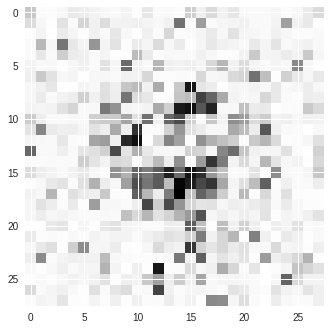

Epoch:  1


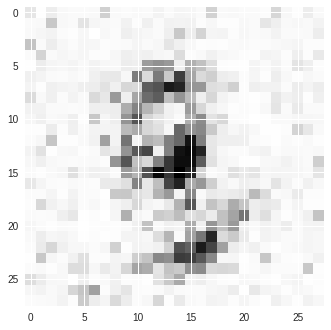

Epoch:  2


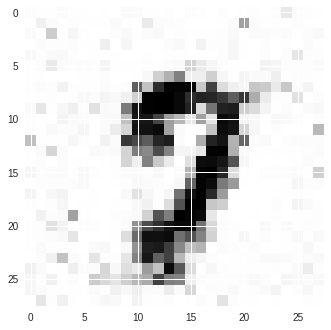

Epoch:  3


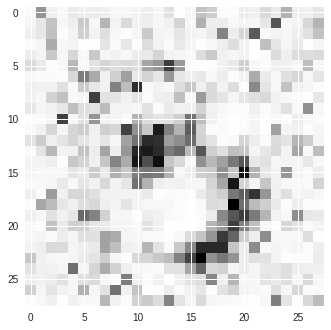

Epoch:  4


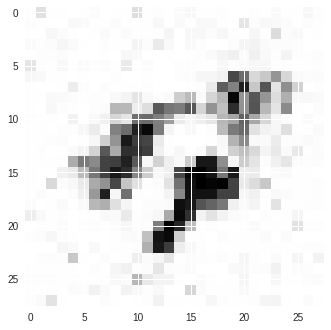

Epoch:  5


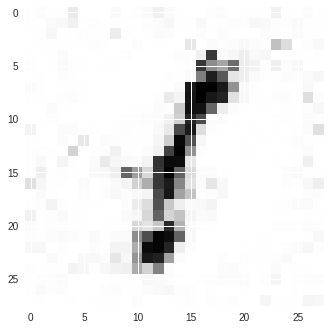

Epoch:  6


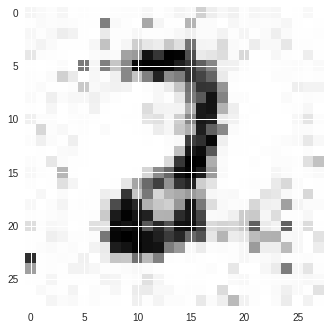

Epoch:  7


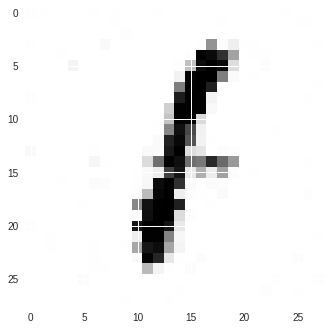

Epoch:  8


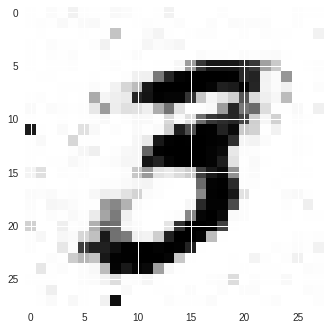

Epoch:  9


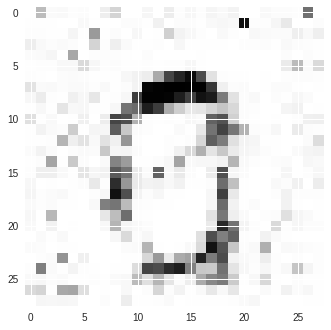

Epoch:  10


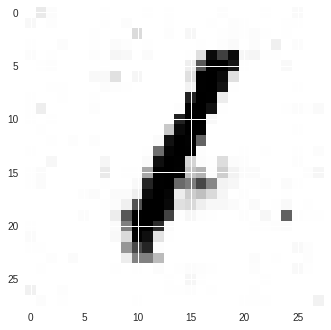

Epoch:  11


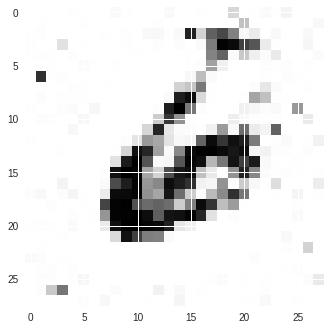

Epoch:  12


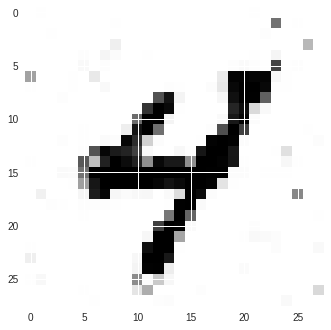

Epoch:  13


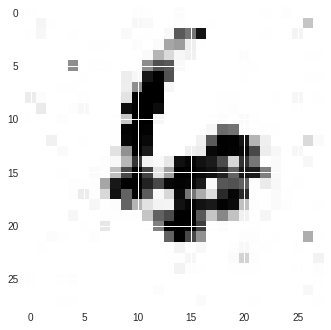

Epoch:  14


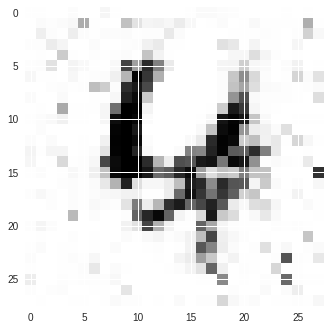

Epoch:  15


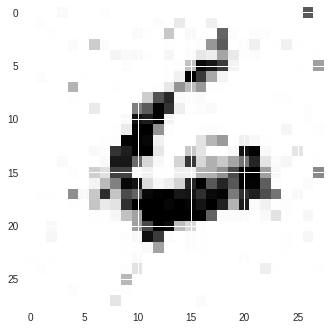

Epoch:  16


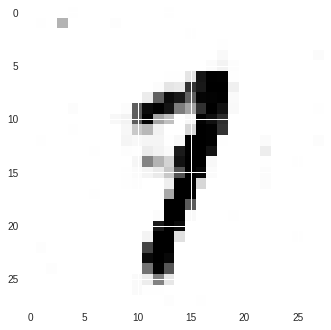

Epoch:  17


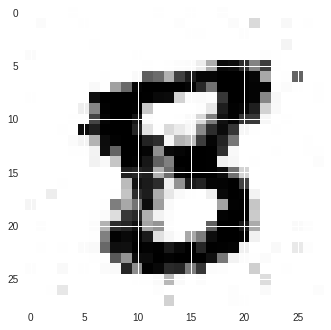

Epoch:  18


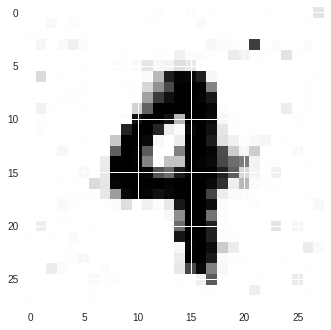

Epoch:  19


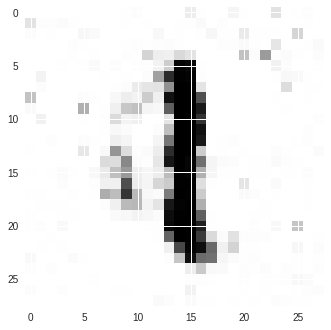

Epoch:  20


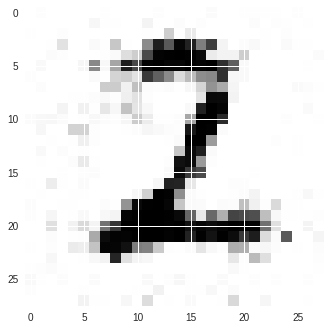

Epoch:  21


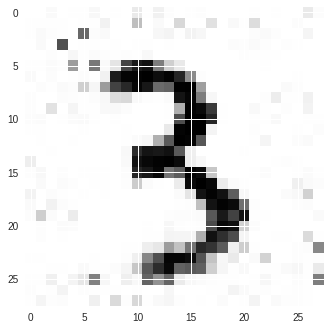

Epoch:  22


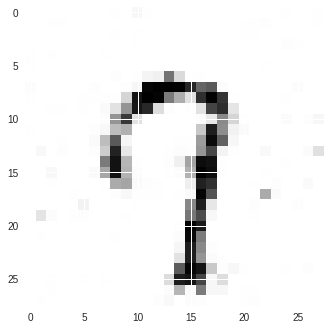

Epoch:  23


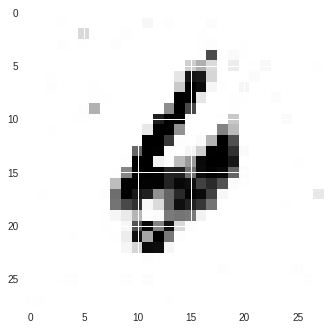

Epoch:  24


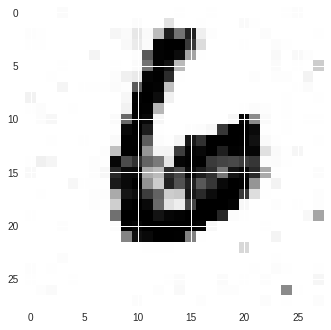

Epoch:  25


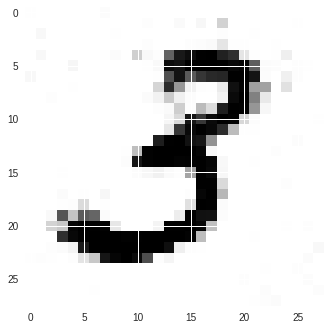

Epoch:  26


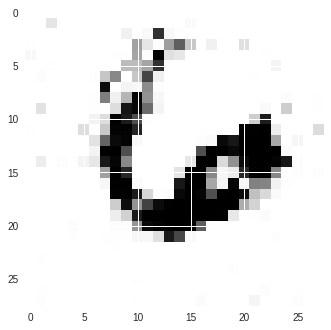

Epoch:  27


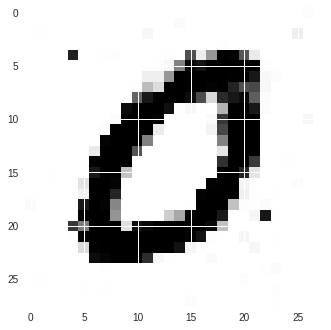

Epoch:  28


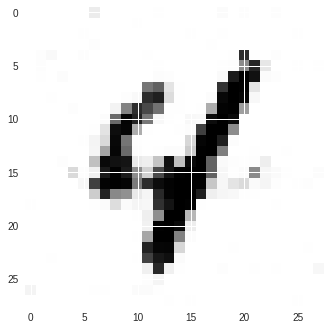

Epoch:  29


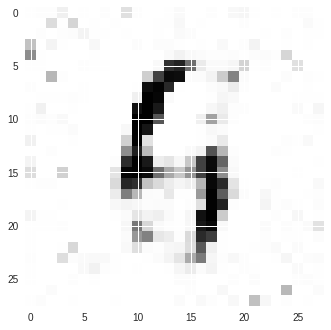

Epoch:  30


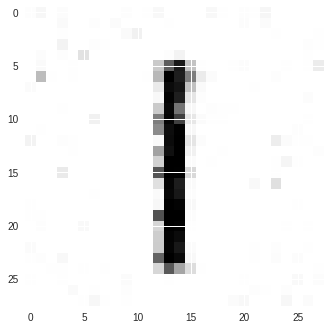

Epoch:  31


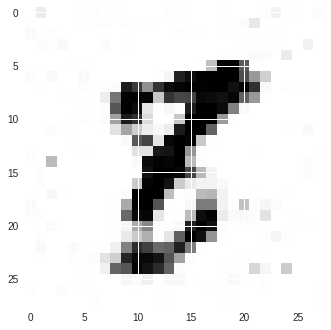

Epoch:  32


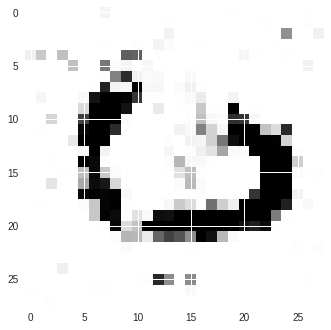

Epoch:  33


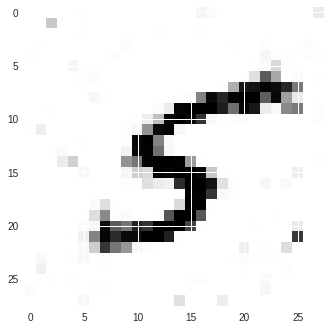

Epoch:  34


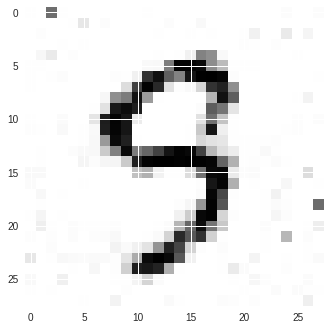

Epoch:  35


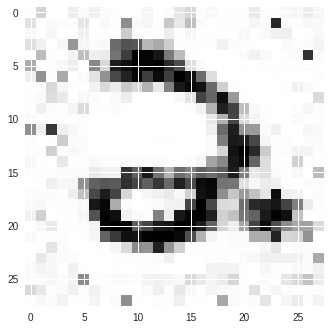

Epoch:  36


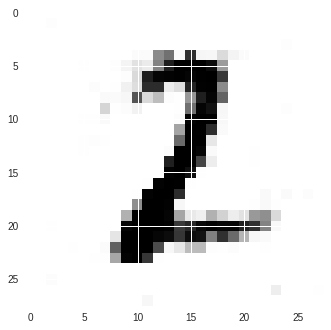

Epoch:  37


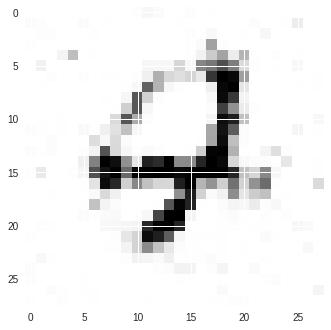

Epoch:  38


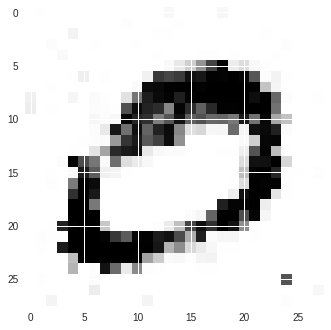

Epoch:  39


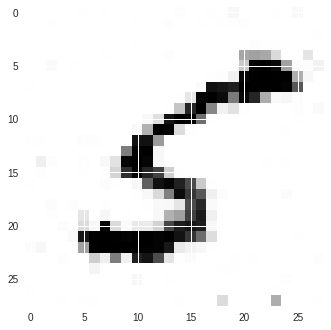

Epoch:  40


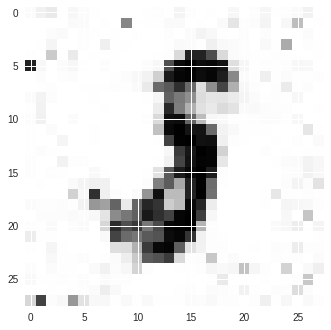

Epoch:  41


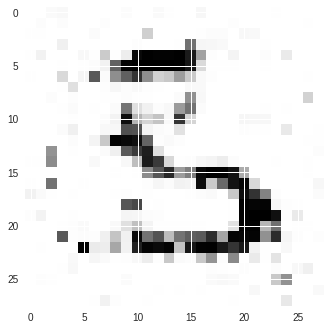

Epoch:  42


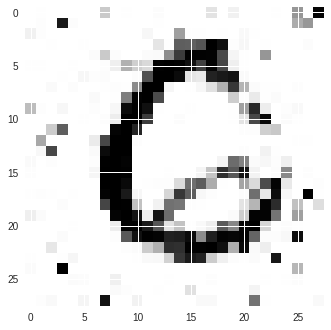

Epoch:  43


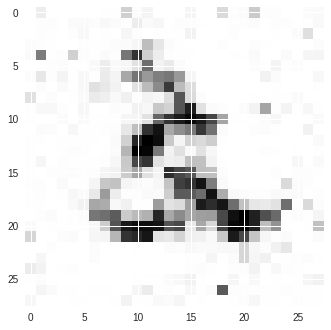

Epoch:  44


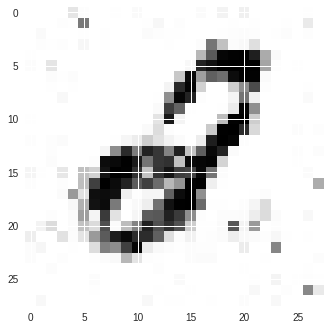

Epoch:  45


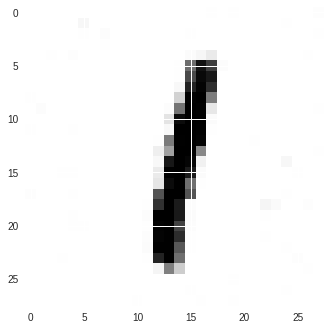

Epoch:  46


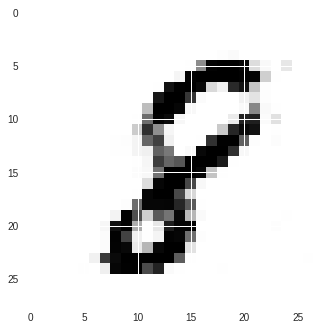

Epoch:  47


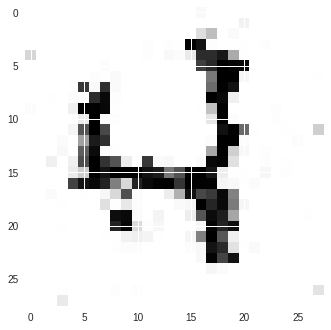

Epoch:  48


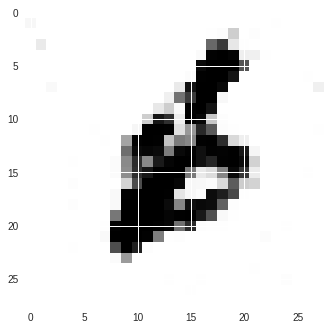

Epoch:  49


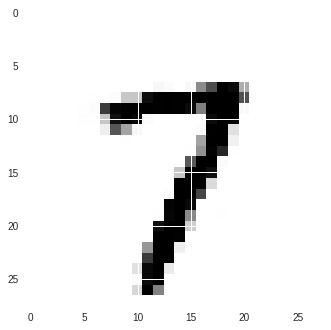

Epoch:  50


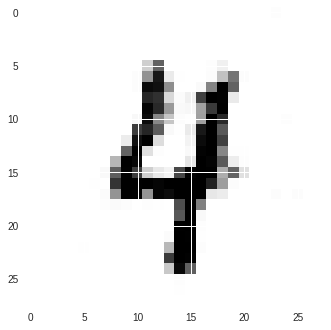

Epoch:  51


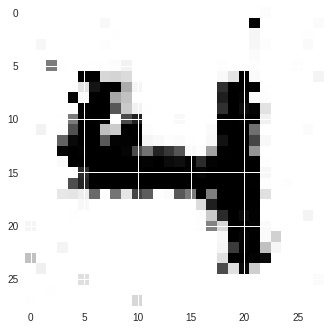

Epoch:  52


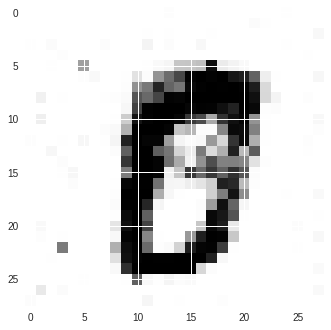

Epoch:  53


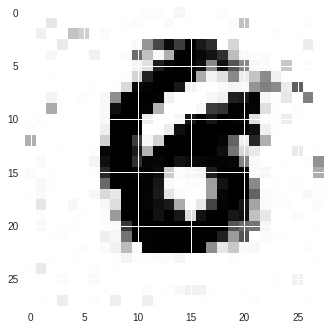

Epoch:  54


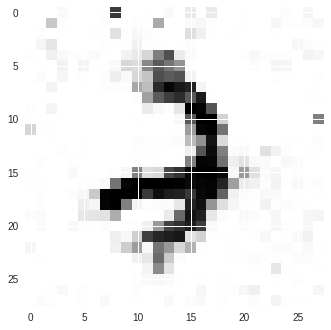

Epoch:  55


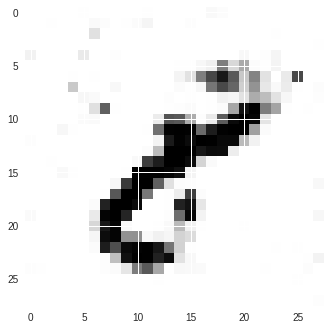

Epoch:  56


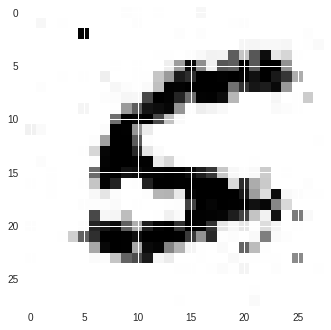

Epoch:  57


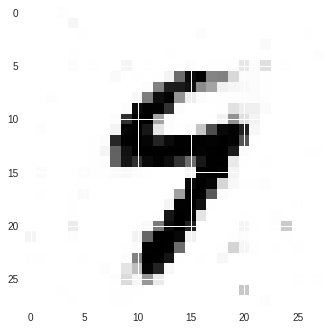

Epoch:  58


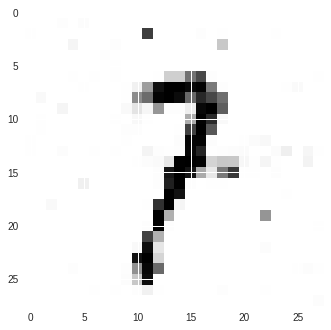

Epoch:  59


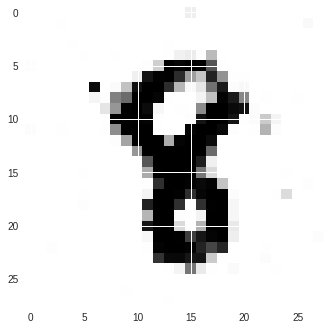

Epoch:  60


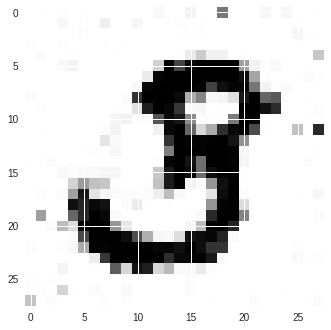

Epoch:  61


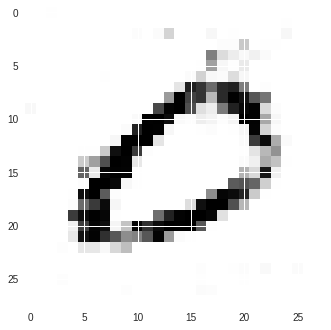

Epoch:  62


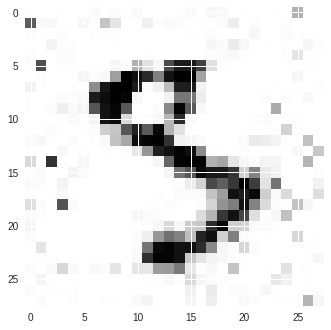

Epoch:  63


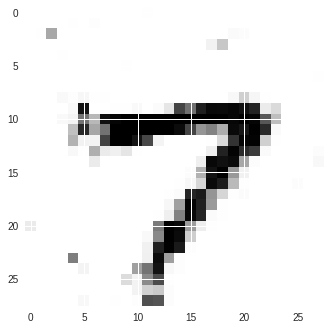

Epoch:  64


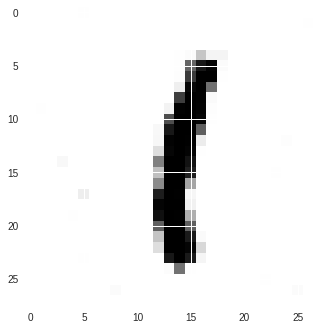

Epoch:  65


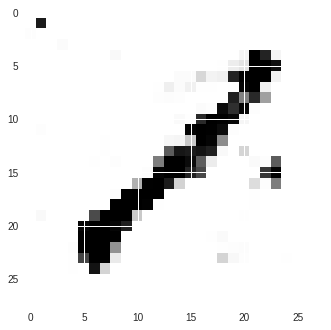

Epoch:  66


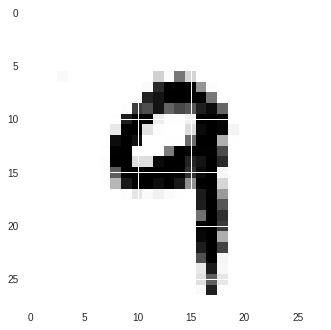

Epoch:  67


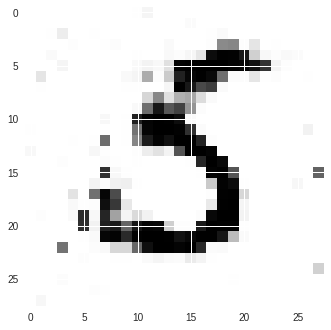

Epoch:  68


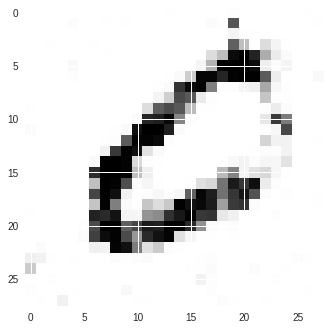

Epoch:  69


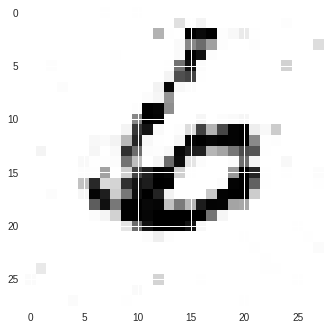

KeyboardInterrupt: ignored

In [13]:
#import libraries
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np

#choose adam for optimzer
optimizer = Adam(0.0002, 0.5)
#set batch size
batch_size = 128

#generator function
def generator():

    #adding leaky ReLU and Batchnormalization known to have improvement
    model = Sequential()

    model.add(Dense(256, input_dim=(28*28)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape((28,28,1)))
    
    model.summary()

    return model

#discriminator function
def discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=(28,28,1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
    inputs = Input(shape=(28,28,1))
    features = model(inputs)
    valid_img = Dense(1,activation='sigmoid')(features)
    
    #output whether the image was a valid or generated fake
    return Model(inputs=inputs,outputs=[valid_img])


#compile discriminator and generator
D = discriminator()
D.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
G = generator()
G.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

#modify input shape to have same dimension as MNIST data
inputs = Input(shape=(28*28,))
gen = G(inputs)
#make sure that discriminator doesn't train while generator is training
D.trainable = False
target_img = D(gen)
stacked = Model(inputs,[target_img])

#compile combined GAN model
stacked.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

#load mnist data
(X_train, y_train), (_, _) = mnist.load_data()
#normalize to -1.0~1.0 scale
X_train = X_train / 127.5 - 1
#add dimensions to fit shape
X_train = np.expand_dims(X_train, axis=3)
#valid if label is 1. fake if label is 0.
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(100):
  for batch in range(int(X_train.shape[0]/batch_size)):
    #grab images by batch size
    imgs = X_train[batch*batch_size:(batch+1)*batch_size]
    #make noise and generate image
    noise = np.random.normal(0,1,(batch_size,28*28))
    fake_imgs = G.predict(noise)
    
    #train discriminator
    D.trainable = True
    d_loss_real = D.train_on_batch(imgs,valid)
    d_loss_fake = D.train_on_batch(fake_imgs,fake)
    
    #train generator with trained discriminator
    noise = np.random.normal(0,1,(batch_size,28*28))
    D.trainable = False
    g_loss = stacked.train_on_batch(noise, [valid])
  #for every epoch print generated image result  
  print("Epoch: ",epoch)
  noise = np.random.normal(0,1,(1,28*28))
  plt.imshow(G.predict(noise).reshape(28,28))
  plt.show()


# Generating MNIST image from existing dataset
Pretty promosing results! However, what will happen if an MNIST data is fed as a random noise? Will it generate a similar data? Let's find out.

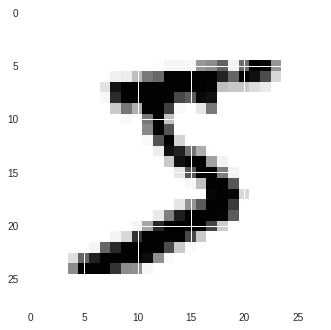

In [14]:
#get an image from MNIST dataset
image = X_train[0].reshape(28,28)
plt.imshow(image)
plt.show()

The number we're feeding in to the GAN as a random noise is '5'. The question is will it also generate '5'?

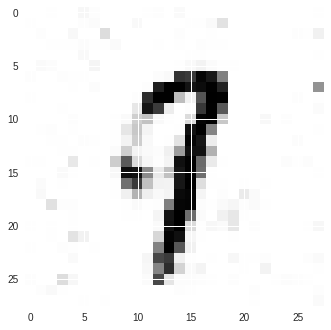

In [15]:
#feed '5' as a random noise to the GAN
image = image.reshape(1,28*28)
plt.imshow(G.predict(image).reshape(28,28))
plt.show()

The result seems like '9' from the GAN output.
So, it looks like just feeding a number to GAN doesn't ensure that the same kind of data is generated.